# Setup

#### Load Packages

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

# import packages
import numpy as np
import matplotlib.pyplot as plt

# import modules
import Bargaining as brg
from figures import *
from checks import *

#### Compile C++ files

In [2]:
# compile c++ files
model = brg.HouseholdModelClass(par={'do_cpp':True,'num_Ctot':100})
try:
    model.link_to_cpp(force_compile=True)
except:
    model.cpp.delink()
    model.link_to_cpp(force_compile=True)

## Model Settings

#### Specify Models

In [3]:
# Default settings
T = 10
do_load = False
do_save = False
threads = 4

# Model settings
specs = {
       'VFI':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'R':1.2,
                     'do_egm':False,
                     'max_A': 15.0,
                     }
              },
              
       'EGM':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'R':1.2,
                     'do_egm':True,
                     'max_A': 15.0,
                     'analytic_marg_u_single':False,
                     'analytic_inv_marg_u_single':False,
                     }
              },
              
       # 'EGM: numeric marg u, numeric inv marg u':    
       #        {'latexname':'', 
       #        'load': do_load,
       #        'save': do_save,
       #        'par':{'T':T,
       #               'do_cpp':True,
       #               'threads':threads,
                     
       #               'div_A_share':0.3,
       #               'sigma_love':0.0,
       #               'R':1.2,
       #               'do_egm':True,
       #               'max_A': 15.0,
       #               'analytic_marg_u_single':False,
       #               'analytic_inv_marg_u_single':False,
       #               }
       #        },
              
       # 'EGM: numeric marg u, analytic inv marg u':     
       #        {'latexname':'', 
       #        'load': do_load,
       #        'save': do_save,
       #        'par':{'T':T,
       #               'do_cpp':True,
       #               'threads':threads,
                     
       #               'div_A_share':0.3,
       #               'sigma_love':0.0,
       #               'R':1.2,
       #               'do_egm':True,
       #               'max_A': 15.0,
       #               'analytic_marg_u_single':False,
       #               'analytic_inv_marg_u_single':True,
       #               }
       #        },
              
       # 'EGM: analytic marg u, numeric inv marg u':     
       #        {'latexname':'', 
       #        'load': do_load,
       #        'save': do_save,
       #        'par':{'T':T,
       #               'do_cpp':True,
       #               'threads':threads,
                     
       #               'div_A_share':0.3,
       #               'sigma_love':0.0,
       #               'R':1.2,
       #               'do_egm':True,
       #               'max_A': 15.0,
       #               'analytic_marg_u_single':True,
       #               'analytic_inv_marg_u_single':False,
       #               }
       #        },
              
       # 'EGM: analytic marg u, analytic inv marg u':    
       #        {'latexname':'', 
       #        'load': do_load,
       #        'save': do_save,
       #        'par':{'T':T,
       #               'do_cpp':True,
       #               'threads':threads,
                     
       #               'div_A_share':0.3,
       #               'sigma_love':0.0,
       #               'R':1.2,
       #               'do_egm':True,
       #               'max_A': 15.0,
       #               'analytic_marg_u_single':True,
       #               'analytic_inv_marg_u_single':True,
       #               }
       #        },
}

In [4]:
# get the first variable of specs
name = list(specs.keys())[0]

In [5]:
# Make table
print_specs_table(specs)

                          |           VFI            |           EGM            |
---------------------------------------------------------------------------------
div_A_share               |           0.3            |           0.3            |
threads                   |            4             |            4             |
analytic_marg_u_single    |          False           |          False           |
do_cpp                    |           True           |           True           |
analytic_inv_marg_u_single|          False           |          False           |
R                         |           1.2            |           1.2            |
T                         |            10            |            10            |
max_A                     |           15.0           |           15.0           |
do_egm                    |          False           |           True           |
sigma_love                |           0.0            |           0.0            |


#### Solve/Load models

In [6]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'solving {name}...')
        
        # setup model
        models[name] = brg.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        models[name].spec = spec
        
        # link to cpp
        try:
            models[name].link_to_cpp(force_compile=False)
        except:
            models[name].cpp.delink()
            models[name].link_to_cpp(force_compile=False)
        
        # solve
        if not do_load:
            models[name].solve()
        
        # save model
        if do_save:
            models[name].save()
        
# Save model names
model_names  = list(models.keys())

solving VFI...
solving EGM...


# Timing

In [7]:
for name in model_names:
    solution_time = models[name].sol.solution_time
    minutes, seconds = divmod(solution_time, 60)
    seconds, ms      = divmod(seconds*100, 100)
    print(f"{name:16}: {int(minutes):2} minutes, {int(seconds):2} seconds, {int(ms):2} ms")


VFI             :  0 minutes,  5 seconds, 82 ms
EGM             :  0 minutes,  0 seconds, 48 ms


## Check values

# Figures

#### User settings

In [8]:
# Choose index
t  = 0
iP = 10
iL = 20
iA = 30
idx = (t,iP,iL,iA)

## Bargaining

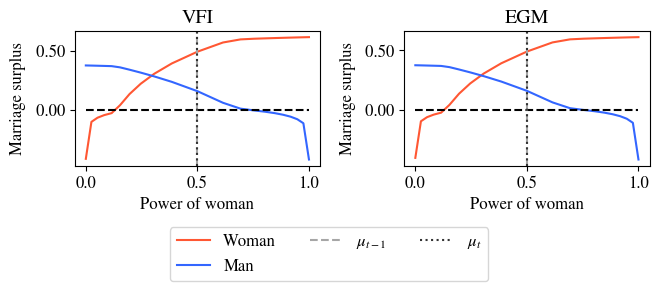

In [9]:
model_plot(models, plot_surplus, [''], t,iP,iL,iA, shared_legend=True, subtitles=model_names)

### Values

Plot female values

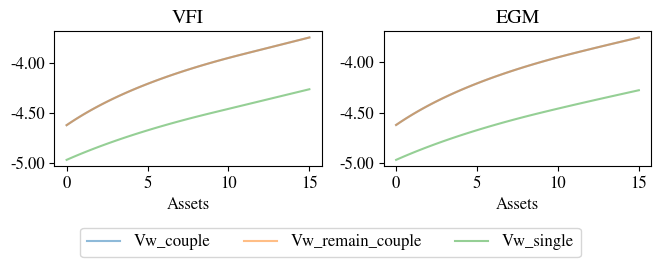

In [10]:
model_plot(models, plot_var_over_assets, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, shared_legend=True, asset_grid='', subtitles=model_names)

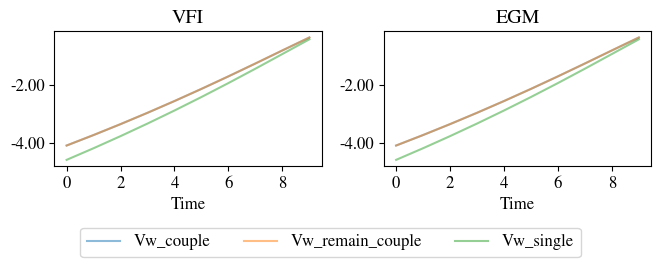

In [11]:
model_plot(models, plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, shared_legend=True, subtitles=model_names)

Plot male values

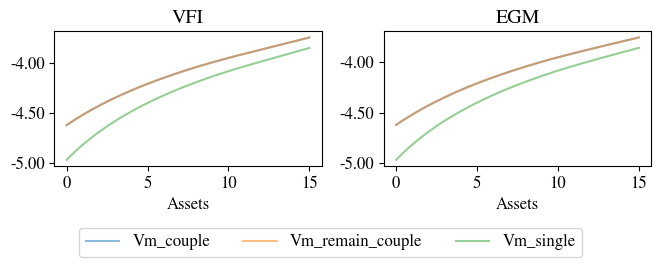

In [12]:
model_plot(models, plot_var_over_assets, ['Vm_couple','Vm_remain_couple','Vm_single'], idx, shared_legend=True, asset_grid='', subtitles=model_names)

### Consumption

Total consumption

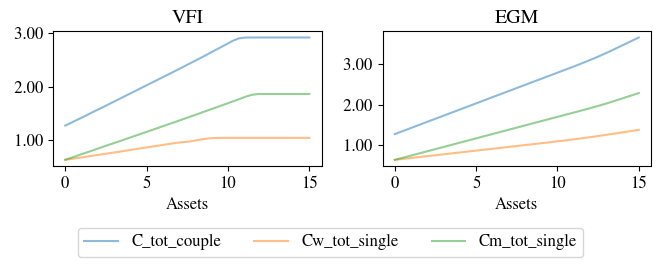

In [13]:
model_plot(models, plot_var_over_assets, ['C_tot_couple','Cw_tot_single','Cm_tot_single'], idx, shared_legend=True, asset_grid='', subtitles=model_names)

Plot female consumption

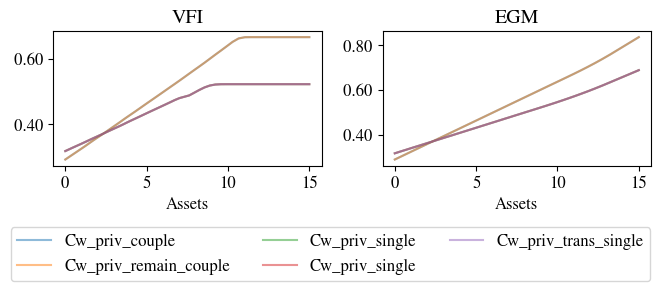

In [14]:
model_plot(models, plot_var_over_assets, ['Cw_priv_couple','Cw_priv_remain_couple','Cw_priv_single','Cw_priv_single', 'Cw_priv_trans_single'], idx, shared_legend=True, asset_grid='', subtitles=model_names)

Plot male consumption

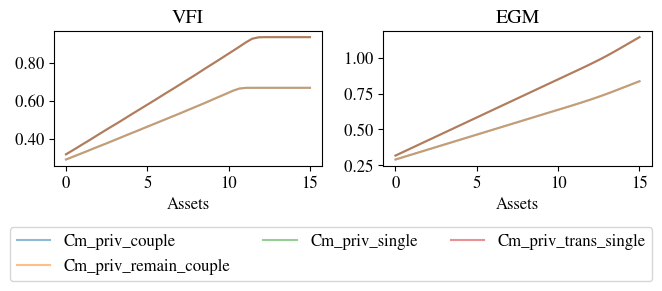

In [15]:
model_plot(models, plot_var_over_assets, ['Cm_priv_couple','Cm_priv_remain_couple','Cm_priv_single', 'Cm_priv_trans_single'], idx, shared_legend=True, asset_grid='', subtitles=model_names)

Plot public consumption

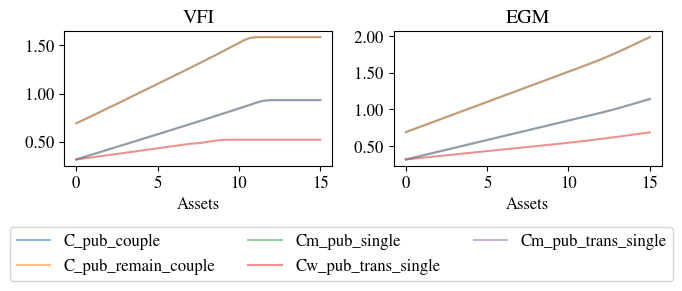

In [16]:
model_plot(models, plot_var_over_assets, ['C_pub_couple','C_pub_remain_couple','Cm_pub_single', 'Cw_pub_trans_single', 'Cm_pub_trans_single', ], idx, shared_legend=True, asset_grid='', subtitles=model_names)

# Var plots

### Values

Plot female values

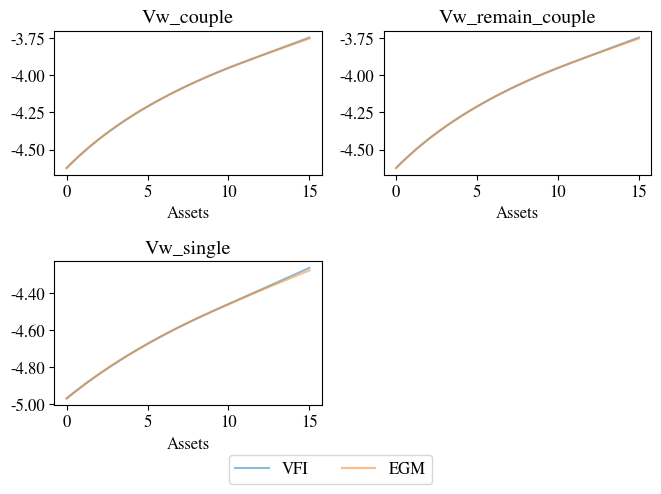

In [17]:
var_plot(models, plot_var_over_assets, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

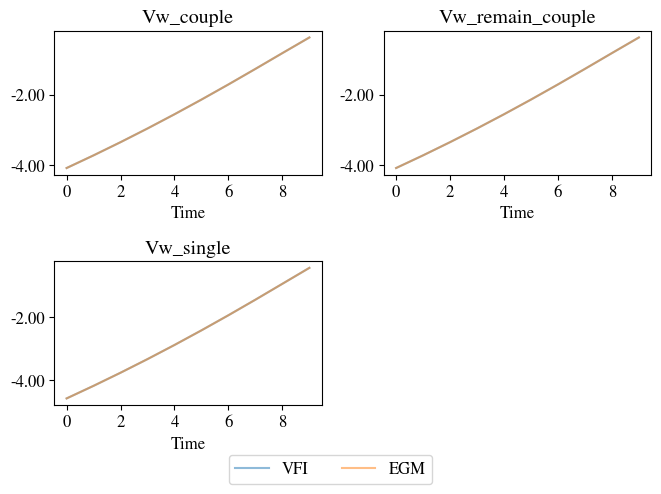

In [18]:
var_plot(models, plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, shared_legend=True, subtitles='var_names')

Plot male values

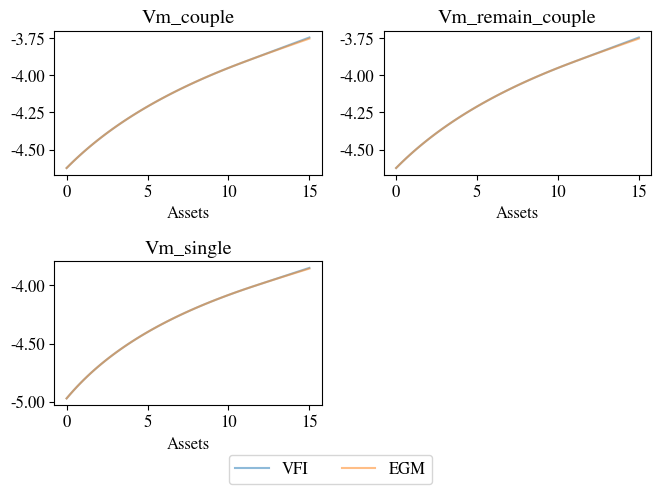

In [19]:
var_plot(models, plot_var_over_assets, ['Vm_couple','Vm_remain_couple','Vm_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

### Consumption

Total consumption

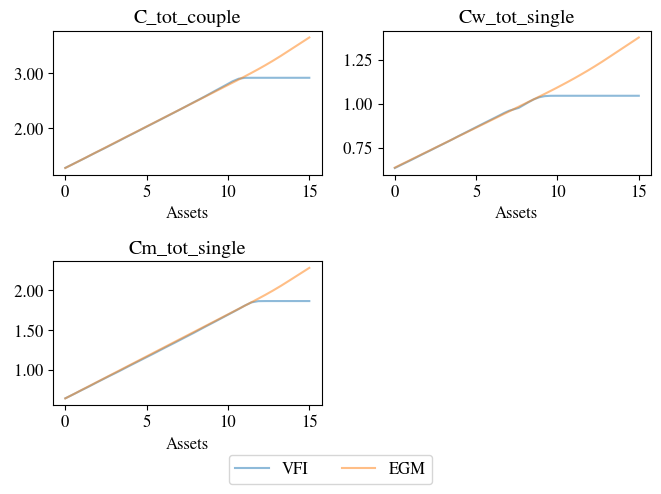

In [20]:
var_plot(models, plot_var_over_assets, ['C_tot_couple','Cw_tot_single','Cm_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

Plot female consumption

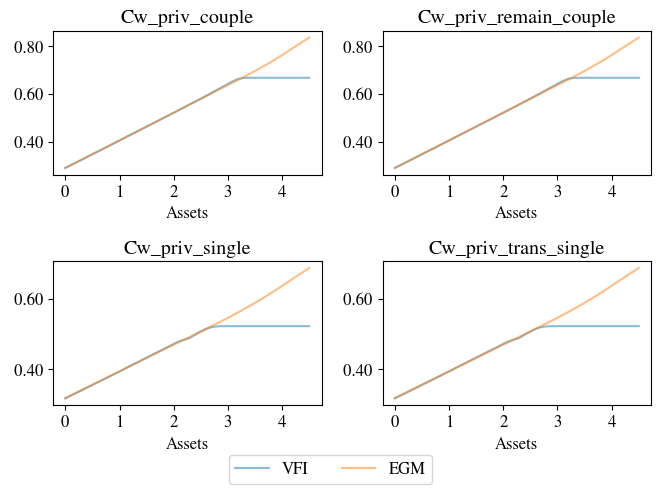

In [21]:
var_plot(models, plot_var_over_assets, ['Cw_priv_couple','Cw_priv_remain_couple','Cw_priv_single', 'Cw_priv_trans_single'], idx, shared_legend=True, asset_grid='grid_Aw', subtitles='var_names')

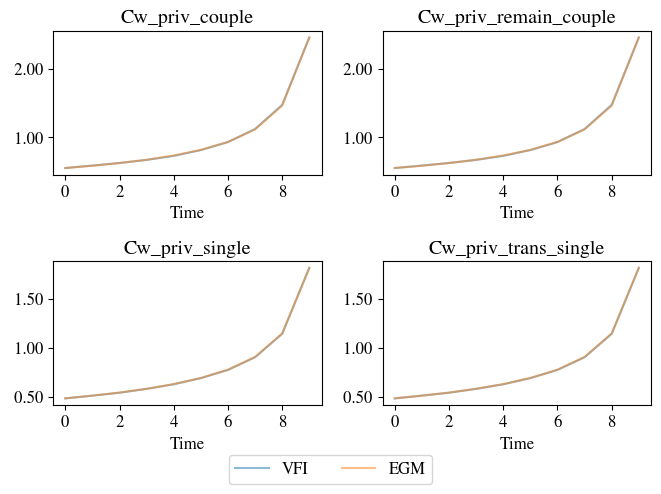

In [22]:
var_plot(models, plot_var_over_time, ['Cw_priv_couple','Cw_priv_remain_couple','Cw_priv_single', 'Cw_priv_trans_single'], idx, shared_legend=True, subtitles='var_names')

Plot male consumption

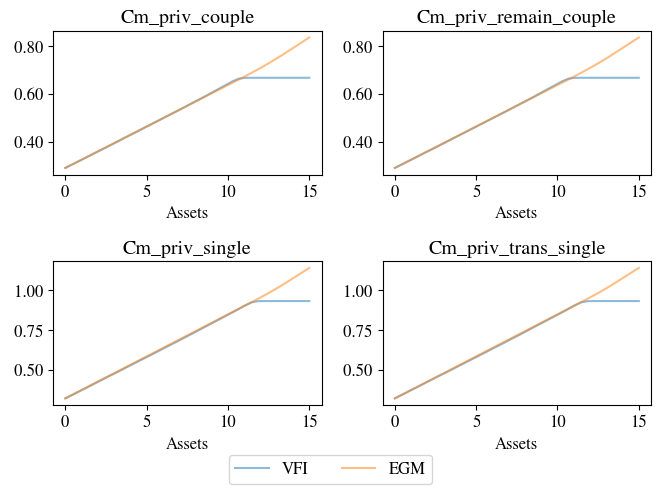

In [23]:
var_plot(models, plot_var_over_assets, ['Cm_priv_couple','Cm_priv_remain_couple','Cm_priv_single', 'Cm_priv_trans_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

Plot public consumption

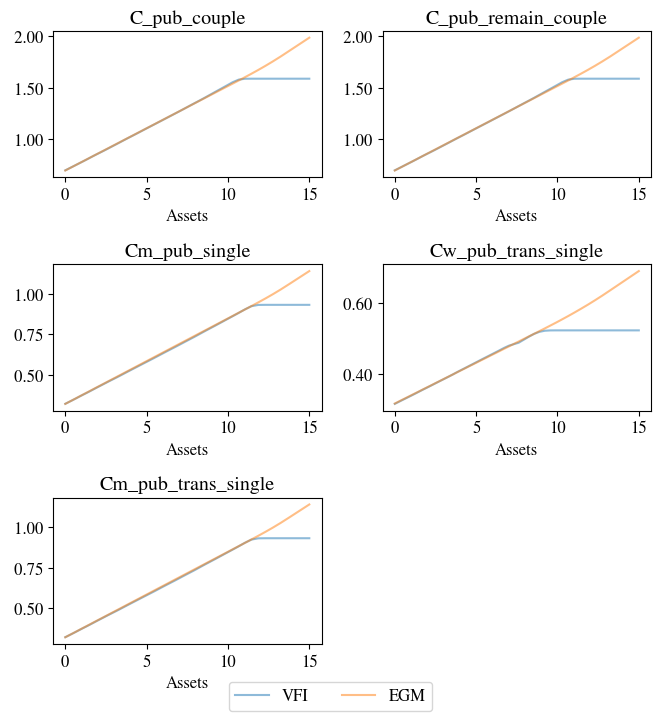

In [24]:
var_plot(models, plot_var_over_assets, ['C_pub_couple','C_pub_remain_couple','Cm_pub_single', 'Cw_pub_trans_single', 'Cm_pub_trans_single', ], idx, shared_legend=True, asset_grid='', subtitles='var_names')

Plot marginal value

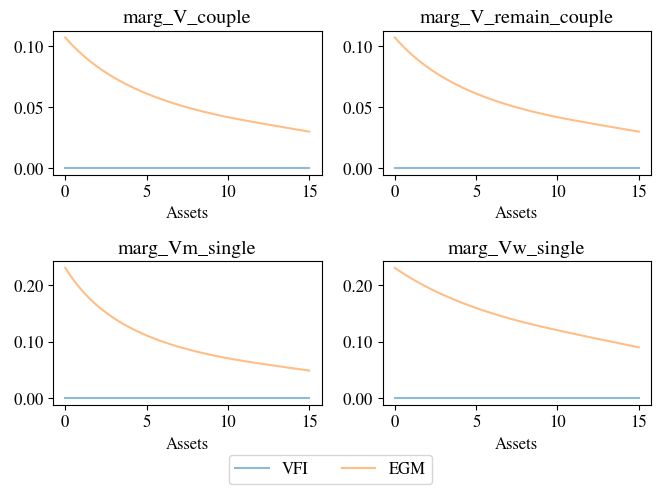

In [25]:
var_plot(models, plot_var_over_assets, ['marg_V_couple', 'marg_V_remain_couple', 'marg_Vm_single', 'marg_Vw_single', ], idx, shared_legend=True, asset_grid='', subtitles='var_names')

# Focus on 2 models

#### Specify models

In [26]:
model1 = models[list(models.keys())[2]]
model2 = models[list(models.keys())[5]]

IndexError: list index out of range

## Calculate differences

#### Absolute differences

Absolute differences

In [ ]:
sol_max_abs_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=False)
print_namespace(sol_max_abs_diff)

Index of absolute differences

In [ ]:
sol_max_abs_diff_index = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)
print_namespace(sol_max_abs_diff_index)

#### Relative differences

Relative differences

In [ ]:
sol_max_rel_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=True)
print_namespace(sol_max_rel_diff)

Index of relative differences

In [ ]:
sol_max_rel_diff_index = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=True)
print_namespace(sol_max_rel_diff_index)

## Find largest difference

Specify the variable that index of maximum absolute difference should be based on

In [ ]:
# Specify the variable that index of maximum absolute difference should be based on
variable = 'Cw_tot_single'

# Specify whether to find the index based on absolute or relative differences
relative = False

Find index with largest difference

In [ ]:
sol_max_diff_idx = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=relative)

In [ ]:
idx = getattr(sol_max_diff_idx,variable)

try: #couple
    t,iP,iL,iA = idx
    print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')
except: #single
    t,iA = idx
    iP = 8
    iL = 20
    idx = t, iP, iL, iA
    print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

## Plots of differences

#### Make model with absolute differences

In [ ]:
model_diff =  brg.HouseholdModelClass(name='Model differences')
model_diff.par = model1.par
model_diff.sol = difference_in_namespace(model1.sol, model2.sol)

### Values

Plot female values

In [ ]:
model_plot([model_diff], plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, shared_legend=True, subtitles=model_names)

Plot male values

In [ ]:
model_plot([model_diff], plot_var_over_time, ['Vm_couple','Vm_remain_couple','Vm_single'], idx, shared_legend=True, subtitles=model_names)

### Consumption

Plot female consumption

In [ ]:
model_plot([model_diff], plot_var_over_time, ['Cw_priv_couple','Cw_priv_remain_couple','Cw_priv_single','Cw_priv_single', 'Cw_priv_trans_single'], idx, shared_legend=True, subtitles=model_names)

Plot male consumption

In [ ]:
model_plot([model_diff], plot_var_over_time, ['Cm_priv_couple','Cm_priv_remain_couple','Cm_priv_single', 'Cm_priv_trans_single'], idx, shared_legend=True, subtitles=model_names)

Plot public consumption

In [ ]:
model_plot([model_diff], plot_var_over_time, ['C_pub_couple','C_pub_remain_couple','Cm_pub_single', 'Cw_pub_trans_single', 'Cm_pub_trans_single', ], idx, shared_legend=True, subtitles=model_names)

Plot consumption

In [ ]:
# plot pre_Ctot_Cw_priv in a 3 dimensional plot with using meshgrids 
fig = plt.figure()
ax = plt.axes(projection='3d')
mesh1, mesh2 = np.meshgrid(model1.par.grid_power, model1.par.grid_Ctot, indexing='ij')

ax.plot_surface(mesh1,mesh2, model_diff.sol.pre_Ctot_Cw_priv, cmap='viridis', edgecolor='none')

# label axes
ax.set_xlabel('Power')
ax.set_ylabel('Ctot')


# Time investigation

In [ ]:
# Choose index
t  = 0
iP = 10
iL = 20
iA = 30
idx = (t,iP,iL,iA)

In [ ]:
t=9
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=8
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=7
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=6
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=5
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=4
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=3
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=2
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=1
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
t=0
idx = (t,iP,iL,iA)
var_plot(models, plot_var_over_assets, ['Cw_tot_single'], idx, shared_legend=True, asset_grid='', subtitles='var_names')

In [ ]:
plt.scatter(model1.par.grid_marg_u_single_w_for_inv[1:-1], model1.par.grid_inv_marg_u[1:-1])

In [ ]:
plt.scatter(model1.par.grid_marg_u_single_w[1:-1], model1.par.grid_Ctot[1:-1])

In [ ]:
model1.par.grid_marg_u.shape